In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Research/SimilaritySearchDemos/primes`


In [2]:
# run this cell only the first time
Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.8.10"),
    PackageSpec(url="https://github.com/sadit/UMAP.jl", rev="0eb586724de41b39dd46f7a3748970c464f57fe3"),
    PackageSpec(name="Plots"),
    PackageSpec(name="Primes"),
    PackageSpec(name="StatsBase")
])


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/Research/SimilaritySearchDemos/primes/Project.toml`
  [053f045d] ~ SimilaritySearch v0.8.10 `../../SimilaritySearch.jl` ⇒ v0.8.10
  [c4f8c510] ~ UMAP v0.2.1 `../../UMAP.jl` ⇒ v0.2.1 `https://github.com/sadit/UMAP.jl#0eb5867`
    Updating `~/Research/SimilaritySearchDemos/primes/Manifest.toml`
  [053f045d] ~ SimilaritySearch v0.8.10 `../../SimilaritySearch.jl` ⇒ v0.8.10
  [c4f8c510] ~ UMAP v0.2.1 `../../UMAP.jl` ⇒ v0.2.1 `https://github.com/sadit/UMAP.jl#0eb5867`
Precompiling project...
  ✓ SimilaritySearch
  ✓ UMAP
  2 dependencies successfully precompiled in 24 seconds (161 already precompiled)


In [3]:

using SimilaritySearch, UMAP, Primes, Plots, StatsBase

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


# Prime numbers
This demonstration is about prime numbers and its similarity based on its factors. This is a well-known demonstration of `UMAP.jl`. This notebook does not requires to download any dataset.



Now, we can define our dataset. The set of factors are found using the `Primes` package. Note that we use `VectorDatabase` to represent the dataset.

In [4]:
n = 100_000
F = Vector{Vector{Int32}}(undef, n)

for i in 2:n+1
    s = Int32[convert(Int32, f) for f in factor(Set, i)]
    sort!(s)
    F[i-1] = s
end

db = VectorDatabase(F)

VectorDatabase{Vector{Int32}}(Vector{Int32}[[2], [3], [2], [5], [2, 3], [7], [2], [3], [2, 5], [11]  …  [2, 29, 431], [3, 33331], [2, 17, 173], [5, 7, 2857], [2, 3, 13, 641], [19, 277], [2, 49999], [3, 41, 271], [2, 5], [11, 9091]])

We use Int32 ordered arrays to store prime factors to represent each integer. In the following cell define the cosine distance equivalent for this representation. While other representations may perform faster, this is quite straighforward and demonstrates the use of user's defined distance functions.

## Index construction
Note that the primes factors are pretty large for some large $n$ and this imply challengues for metric indexes (since it is related with the intrinsic dimension of the dataset). We used a kernel that starts 64 threads, it solves $100000$ in a few seconds but it can take pretty large time using single threads and larger $n$ values. The construction of the index is used by the visualization algorithm (UMAP) to construct an all-knn graph, which can be a quite costly procedure.

In [5]:
#dist = JaccardDistance()  # Other distances from SimilaritySearch
dist = DiceDistance()
#dist = IntersectionDissimilarity()
#dist = CosineDistanceSet()
G = SearchGraph(; db, dist)
index!(G; parallel_block=1000)
IJulia.clear_output()

0

## Visualizing with UMAP projection
We select to initialize the embedding randomly, this could yield to low quality embeddings, but it is much faster than other techniques like spectral layout. Note that we pass the Search graph `G`. We also use a second call to compute a 3D embedding for computing a kind of colour embedding, here we pass `U2` to avoid recomputing several of the involved structures.

In [16]:
#layout = RandomLayout()
layout = KnnGraphComponentsLayout()
n_epochs = 50
n_neighbors = 50
U2 = UMAP_(G, 2; n_neighbors, layout, n_epochs)
U3 = UMAP_(U2, 3; layout, n_epochs)

(n, n_neighbors, n_components) = (100000, 50, 2)
  0.027811 seconds (332 allocations: 57.251 MiB)
 40.911133 seconds (16.15 k allocations: 1.498 MiB)
 42.404580 seconds (16.15 k allocations: 1.498 MiB)


*** computing allknn graph
*** computing graph
*** layout embedding KnnGraphComponentsLayout
*** fit ab / embedding
*** opt embedding


UMAP_{SparseArrays.SparseMatrixCSC{Float32, Int32}, Matrix{Float32}, SearchGraph{DiceDistance, VectorDatabase{Vector{Int32}}, BeamSearch}}(sparse(Int32[3, 5, 7, 15, 31, 33, 37, 63, 127, 255  …  2100, 2122, 2166, 2188, 2320, 2452, 2518, 2562, 9090, 14640], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.035736274, 0.035736274, 0.035736274, 0.035736274, 0.035736274, 0.035736274, 0.035736274, 0.035736274, 1.0, 1.0], 100000, 100000), Float32[-4.244221 -0.6767954 … 9.542291 8.862421; 9.151265 -0.36095837 … -8.455304 1.8946815; -2.559197 -6.9280124 … 4.3530545 -2.9082804], SearchGraph{DiceDistance, VectorDatabase{Vector{Int32}}, BeamSearch}
  dist: DiceDistance DiceDistance()
  db: VectorDatabase{Vector{Int32}}
  links: Array{Vector{Int32}}((100000,))
  locks: Array{Base.Threads.SpinLock}((100000,))
  hints: Array{Int32}((117,)) Int32[124, 1412, 1534, 1726, 1747, 

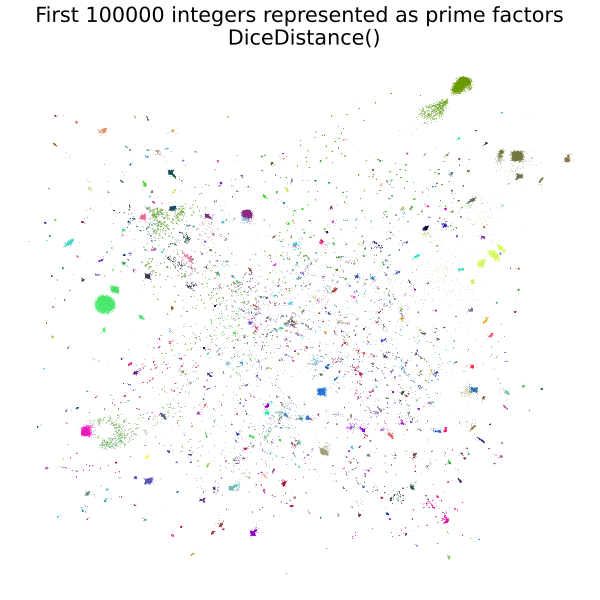

In [17]:
X = @view U2.embedding[1, :]
Y = @view U2.embedding[2, :]

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

C = copy(U3.embedding)
normcolors(@view C[1, :])
normcolors(@view C[2, :])
normcolors(@view C[3, :])

C = [RGB(c...) for c in eachcol(C)]

scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=1, msw=0, label="", yticks=nothing, xticks=nothing, xaxis=false, yaxis=false, title="First $n integers represented as prime factors\n $dist")
#savefig("umap-primes-1M.png")